### ANÁLISE E PREVISÃO DA ARRECADAÇÃO FEDERAL

Autor: GABRIEL RODRIGUES  MARCOLINI

In [1]:
#Biblioteca para ignorar os warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
#Define função para calcular o MAPE - Mean Absolute Percentage Error
def mape(y_pred,y_true):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
# fix random seed for reproducibility
np.random.seed(100)


In [5]:
#Define parâmetros iniciais
dataset_path = '.\\dataset\\CSV\\'
filename_input = 'arrecadacao-TOTAL-GERAL-2015-2020.csv'
indicadores = 'xgdvConsulta.csv'

#Faz a leitura dos datasets
#tb = tabela de Arrecadação Federal
#ie = tabela de indicadores econômicos
tb = pd.read_csv(dataset_path+filename_input) 
ie = pd.read_csv(dataset_path+indicadores,sep=';',decimal=',')

#Ajusta o campo DATA do dataframe ie
ie['DATA'] =  pd.to_datetime(ie['DATA'],format="%m/%Y") + pd.tseries.offsets.MonthEnd(0)
#Ajusta o campo DATA do dataframe tb
tb['DATA'] = pd.to_datetime(tb['DATA'],format="%Y/%m/%d")

#Unindo os dataframes tb + ie
left = tb.groupby([tb['DATA']]).sum()
right = ie
result = pd.merge(left,right,how='inner',on='DATA')

# Criando um novo DF para tratar os desvios de arrecadação (outliers) observados em 10/2016 e 04, 05 e 06/2020.
# Os valores serão substitudo pelo valor arrecadado no mesmo mês do ano anterior. 
#outliers = ['2016-10-31','2020-04-30','2020-05-31','2020-06-30']

result_n = result.copy()

result_n.loc[(result_n['DATA'] == '2016-10-31'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2015-10-31'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-04-30'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-04-30'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-05-31'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-05-31'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-06-30'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-06-30'),'VALOR'].values


# Ajustar parâmetros de plotagem
#plt.rcParams.keys()
plt.rcParams["text.color"] = 'Blue'
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["lines.linewidth"] = 2.0


In [6]:
# Definindo o dataset a ser analisado
df_real = result.groupby([result['DATA']]).sum()['VALOR']
df_normal = result_n.groupby([result_n['DATA']]).sum()['VALOR']
dataset = df_normal.values
raw_values = df_normal.values

## Modelo LSTM

###### Referência e Créditos
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [7]:
# Converte um array em uma matriz de dados
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [8]:
# Normalizar o dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = dataset.reshape(-1,1)
dataset = scaler.fit_transform(dataset)

In [9]:
# Dividir o dataset em treino e teste 
train, test = dataset[0:48], dataset[-30:]

In [10]:
# Criar a base de dados para aprendizado supervisionado (X=t e Y=t+1)
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
# Remodelando dataset para entrada no modelo lSTM [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [12]:
# Fixando uma semente para repetição do resultado
np.random.seed(1)

# Cria e treina o modelo LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [13]:
# Fazendo as previsões para teste
testPredict = model.predict(testX)

In [14]:
# Inverter a escala da previsão
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [15]:
# Define o campo DATA como indice das séries
yhat = pd.Series (testPredict[:,0], index=result['DATA'][-testPredict.size:])
test = pd.Series(testY[0], index=result['DATA'][-testPredict.size:])

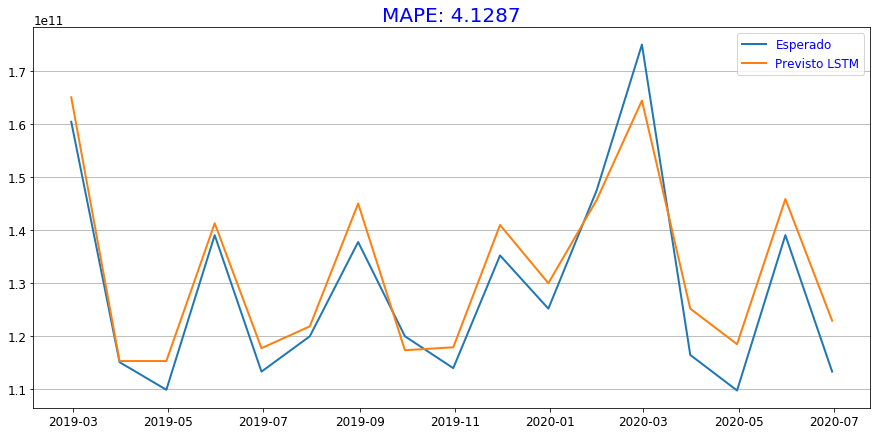

In [16]:
# Plota o valor observado vs previsto. 
plt.plot(test, label='Esperado')
plt.plot(yhat, label='Previsto LSTM')
plt.legend()
plt.title('MAPE: %.4f' % mape(yhat, test))
plt.grid(True,axis='y')
plt.show()

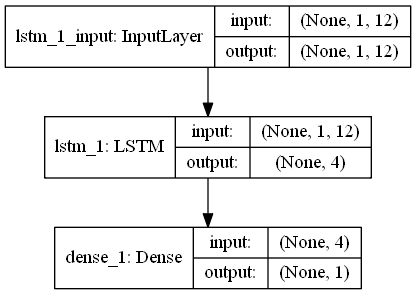

In [17]:
plot_model(model, show_shapes=True)

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________
